In [2]:
# Code source: Sebastian Curi and Andreas Krause.

# Python Notebook Commands
%matplotlib inline
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

# Numerical Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 5)  # Change this if figures look ugly. 

# IPython Libraries
import IPython
import ipywidgets
from IPython.display import display
from ipywidgets import interact, interactive, interact_manual


# sklearn library
import sklearn
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

# Custom Libraries
from utilities import plot_helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model Selection 

In this task we have noisy samples of the function $f(x) = x \sin(x) $, and our objective is to learn it from data (here we're cheating because we already know the function). 

In this demo we will see how model selection works and how to use K-fold cross-validation. 

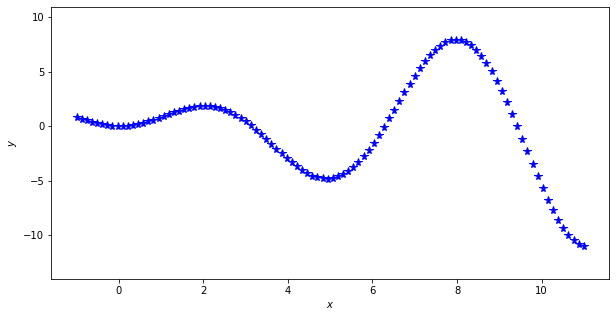

In [3]:
# Let's plot the function first (without noise)
def f(x):
    return x * np.sin(x) 

x_plot = np.linspace(-1, 11, 100)
f_plot = f(x_plot)
X_plot = x_plot[:, np.newaxis]


plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'y_lim': [np.min(f_plot)-3, np.max(f_plot)+3], 
                     'legend':False, 'legend_loc': 'lower left'}
plot_helpers.plot_data(x_plot, f_plot, fig=plt.subplot(111), options=plot_opts)

In [6]:
noise_widget = ipywidgets.FloatSlider(value=1,
                                      min=0,
                                       max=3,
                                       step=0.5,
                                       readout_format='.1f',
                                       description='Noise level:',
                                       style={'description_width': 'initial'},
                                       continuous_update=False)
resample_button = ipywidgets.ToggleButton(description="Resample!")

degree_widget = ipywidgets.IntSlider(min=1,
                                     max=19,
                                     step=1,
                                     description='Polynomial Degree:',
                                     style={'description_width': 'initial'},
                                     continuous_update=False)
reg_widget = ipywidgets.FloatSlider(value=-3,
                                      min=-3,
                                      max=3,
                                      step=0.1,
                                      readout_format='.1f',
                                      description='Regularizer 10^:',
                                      style={'description_width': 'initial'},
                                      continuous_update=False)
def resample(b, noise):
    x = 10 * np.random.rand(20)

    y = f(x) + np.random.normal(size=(20,)) * noise

    # create matrix versions of these arrays
    X = x[:, np.newaxis]

    def change_degree(degree, reg):
        model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=10 ** reg))
        model.fit(X, y) 
        
        fig = plt.figure()
        lw = 2
        plt.plot(x_plot, f_plot, color='cornflowerblue', linewidth=lw, label="Ground Truth")
        y_plot = model.predict(X_plot)
        plt.plot(x_plot, y_plot, color='r', linewidth=lw, label="Degree %d" % degree)
        
        plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'y_lim': [np.min(f_plot)-3, np.max(f_plot)+3], 
                     'legend':True, 'legend_loc': 'lower left'}
        
        opts = {'marker': 'b*', 'label': 'Training Points'}
        plot_opts.update(opts)
        
        plot_helpers.plot_data(X, y, fig=fig.gca(), options=plot_opts)
        plt.show()
        coefs = model._final_estimator.coef_
        coefs[0] = model._final_estimator.intercept_
        print("Estimated coefficients{}".format(coefs))
        

    interact(change_degree, degree=degree_widget, reg=reg_widget);
interact(resample, b=resample_button, noise=noise_widget);


interactive(children=(ToggleButton(value=False, description='Resample!'), FloatSlider(value=1.0, continuous_up…

# K-Fold Cross-Validation

The idea of this method is to split the dataset into K different bins, use K-1 to learn and 1 to validate. Then you can interchange which split you validate on and make statistics on the different errors on each split (such as avg, std, etc). 

In [8]:
folds = 5
N = 50
n = int(N/folds)
resample_button = ipywidgets.ToggleButton(description="Resample!")

degree_widget = ipywidgets.IntSlider(value=1,
                                     min=1,
                                     max=19,
                                     step=1,
                                     description='Polynomial Degree:',
                                     style={'description_width': 'initial'},
                                     continuous_update=False)
fold_widget = ipywidgets.ToggleButtons(value=1,
                                       options=np.arange(1, folds+1),
                                       description='Validation fold:',
                                       style={'description_width': 'initial'},
                                       continuous_update=False)
noise_widget = ipywidgets.FloatSlider(value=1, 
                                      min=0, 
                                      max=3, 
                                      step=0.5, 
                                      readout_format='.1f',
                                      description='Noise level:', 
                                      style={'description_width': 'initial'},
                                      continuous_update=False)

reg_widget = ipywidgets.FloatSlider(value=-3,
                                      min=-3,
                                      max=3,
                                      step=0.1,
                                      readout_format='.1f',
                                      description='Regularizer 10^:',
                                      style={'description_width': 'initial'},
                                      continuous_update=False)
def resample(b, noise):
    xraw = 10 * np.random.rand(N)
    # rng = np.random.RandomState(0)
    np.random.shuffle(xraw)

    #noise=1

    x = dict()
    y = dict()
    for i in range(folds):
        x[i] = xraw[n*i:n*(i+1)]
        y[i] = f(x[i]) + np.random.normal(size=(n,)) * noise

    
    def change_degree(degree, reg, fold):
        X = np.array(())
        Y = np.array(())
        for i in range(folds):
            if i == (fold-1):
                Xval = x[i]
                Yval = y[i]
            else:
                X = np.concatenate((X, x[i]))
                Y = np.concatenate((Y, y[i]))


        X = X[:, np.newaxis]
        Xval = Xval[:, np.newaxis]

        model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=10 ** reg))

        model.fit(X, Y)
        
        fig = plt.subplot(111)
        lw = 2
        plt.plot(x_plot, f_plot, color='cornflowerblue', linewidth=lw, label="Ground Truth")
        y_plot = model.predict(X_plot)
        plt.plot(x_plot, y_plot, color='r', linewidth=lw, label="Degree %d" % degree)
        
        opts = {'marker': 'b*', 'label': 'Training Points'}
        plot_helpers.plot_data(X, Y, fig=fig, options=opts)
        
        plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'y_lim': [np.min(f_plot)-3, np.max(f_plot)+3], 
                     'legend':True, 'legend_loc': 'lower left'}
        opts = {'marker': 'mX', 'label': 'Validation Points'}
        plot_opts.update(opts)
        plot_helpers.plot_data(Xval, Yval, fig=fig, options=plot_opts)
        
        plt.show()
        print("Train. Error: {:.2f}".format(1/X.size * np.linalg.norm(model.predict(X) - Y, 2)))
        print("Valid. Error: {:.2f}".format(1/Xval.size * np.linalg.norm(model.predict(Xval) - Yval, 2)))
        
        
    interact(change_degree, degree=degree_widget, reg=reg_widget, fold=fold_widget);

interact(resample, b=resample_button, noise=noise_widget);

interactive(children=(ToggleButton(value=False, description='Resample!'), FloatSlider(value=1.0, continuous_up…